## Imports

In [1]:
#Data loading
from scipy.io import arff
#General
import pandas as pd
import numpy as np
from numpy import std, mean, sqrt
import tensorflow as tf
import math
#Statistics
from scipy.stats import normaltest
from scipy.stats import chisquare
from scipy.stats import ttest_ind
#Visualization
from matplotlib import pyplot as plt
import matplotlib
#Utility
from tabulate import tabulate

/home/paf/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/paf/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/paf/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/paf/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:4

In [2]:
#Importing my ml folder
import sys
sys.path.insert(0, '/home/paf/workspace-python/ml')
sys.path.insert(1, '/home/paf/workspace-python/ml/models')

In [3]:
#Custom imports
from stat_util import normal_test_all_model_samples
from stat_util import t_test_model_samples_against_other_model_samples
from stat_util import cohen_d_test_model_samples_against_other_model_samples

## Dataset preparation

In [4]:
datasets = ["cm1","jm1","kc1","kc2","pc1"]
main_model_name = "REPD"

In [5]:
main_df = None

for dataset in datasets:
    print("Analyzing:", dataset)
    results_df = pd.read_csv("results/"+dataset)
    results_df = results_df.drop(columns=["Unnamed: 0"])
    results_df = results_df.assign(Dataset=lambda x: dataset)
    if main_df is None:
        main_df = results_df
    else: 
        main_df = pd.concat([main_df,results_df])
    
    
    #Analysis
    
    #Testing if the samples come from a normal distribution
    normal_test_results = normal_test_all_model_samples(results_df,'F1 score')
    normal_df = pd.DataFrame(normal_test_results,columns=['Model','Is normal','normal-test-p','k2-normal'])
    test_df = normal_df
    
    #Statistical difference test t-test
    #For F1 score
    t_test_results = t_test_model_samples_against_other_model_samples(results_df,main_model_name,'F1 score')
    t_test_df = pd.DataFrame(t_test_results,columns=['Model','Different mean values-t-test','statistic-t-test','t-test-p'])
    test_df = pd.merge(test_df, t_test_df, how='inner', on=['Model'])

    #Statistical effect size using cohen_d measure
    #For F1 score
    f1_cohen_d_results = cohen_d_test_model_samples_against_other_model_samples(results_df,main_model_name,'F1 score')
    cohen_d_df = pd.DataFrame(f1_cohen_d_results,columns=['Model','effect-size','effect-interpretation'])
    test_df = pd.merge(test_df, cohen_d_df, how='inner', on=['Model'])
    
    #Printing all results
    test_df = test_df.drop(columns=["k2-normal","statistic-t-test"])
    print(test_df.to_latex())
    print("\n\n")

Analyzing: cm1
\begin{tabular}{lllrlrrl}
\toprule
{} &                   Model & Is normal &  normal-test-p & Different mean values-t-test &      t-test-p &  effect-size & effect-interpretation \\
\midrule
0 &              GaussianNB &       yes &       0.290353 &                           no &  9.580997e-01 &     0.013624 &               trivial \\
1 &      LogisticRegression &       yes &       0.132705 &                          yes &  6.399990e-06 &     1.281695 &                 large \\
2 &    KNeighborsClassifier &        no &       0.000005 &                          yes &  6.904482e-15 &     2.687346 &                 large \\
3 &  DecisionTreeClassifier &       yes &       0.469108 &                          yes &  1.088231e-04 &     1.072473 &                 large \\
4 &                    HSME &       yes &       0.446950 &                           no &  9.573633e-02 &     0.437245 &                 small \\
\bottomrule
\end{tabular}




Analyzing: jm1
\begin{tabular}{lll

In [6]:
grouped_main_df = main_df.groupby(["Dataset","Model"])["F1 score","Accuracy","Recall","Precision","PF","PD"].mean()


grouped_main_df['Balance'] = grouped_main_df.apply(lambda row: 1-(((0-row.PF)**2 + (1-row.PD)**2)**0.5/(2**0.5)), axis=1)



print(grouped_main_df)

                                F1 score  Accuracy    Recall  Precision  \
Dataset Model                                                             
cm1     DecisionTreeClassifier  0.167734  0.535181  0.174361   0.177207   
        GaussianNB              0.275529  0.597583  0.280807   0.287190   
        HSME                    0.235468  0.580674  0.309043   0.211509   
        KNeighborsClassifier    0.063455  0.505192  0.048323   0.105556   
        LogisticRegression      0.125729  0.534023  0.088584   0.286760   
        REPD                    0.277104  0.645162  0.681867   0.177251   
jm1     DecisionTreeClassifier  0.323358  0.561061  0.334528   0.313452   
        GaussianNB              0.208079  0.546122  0.132264   0.489861   
        HSME                    0.349593  0.589535  0.306363   0.411305   
        KNeighborsClassifier    0.264387  0.545648  0.220194   0.331251   
        LogisticRegression      0.155053  0.532494  0.092586   0.502375   
        REPD             

In [7]:
group_df = main_df.drop(columns=["Recall","PD","PF",'Accuracy', 'Precision']).rename(index=str, columns={"F1 score": "F1"}).groupby(["Dataset","Model"])

/home/paf/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


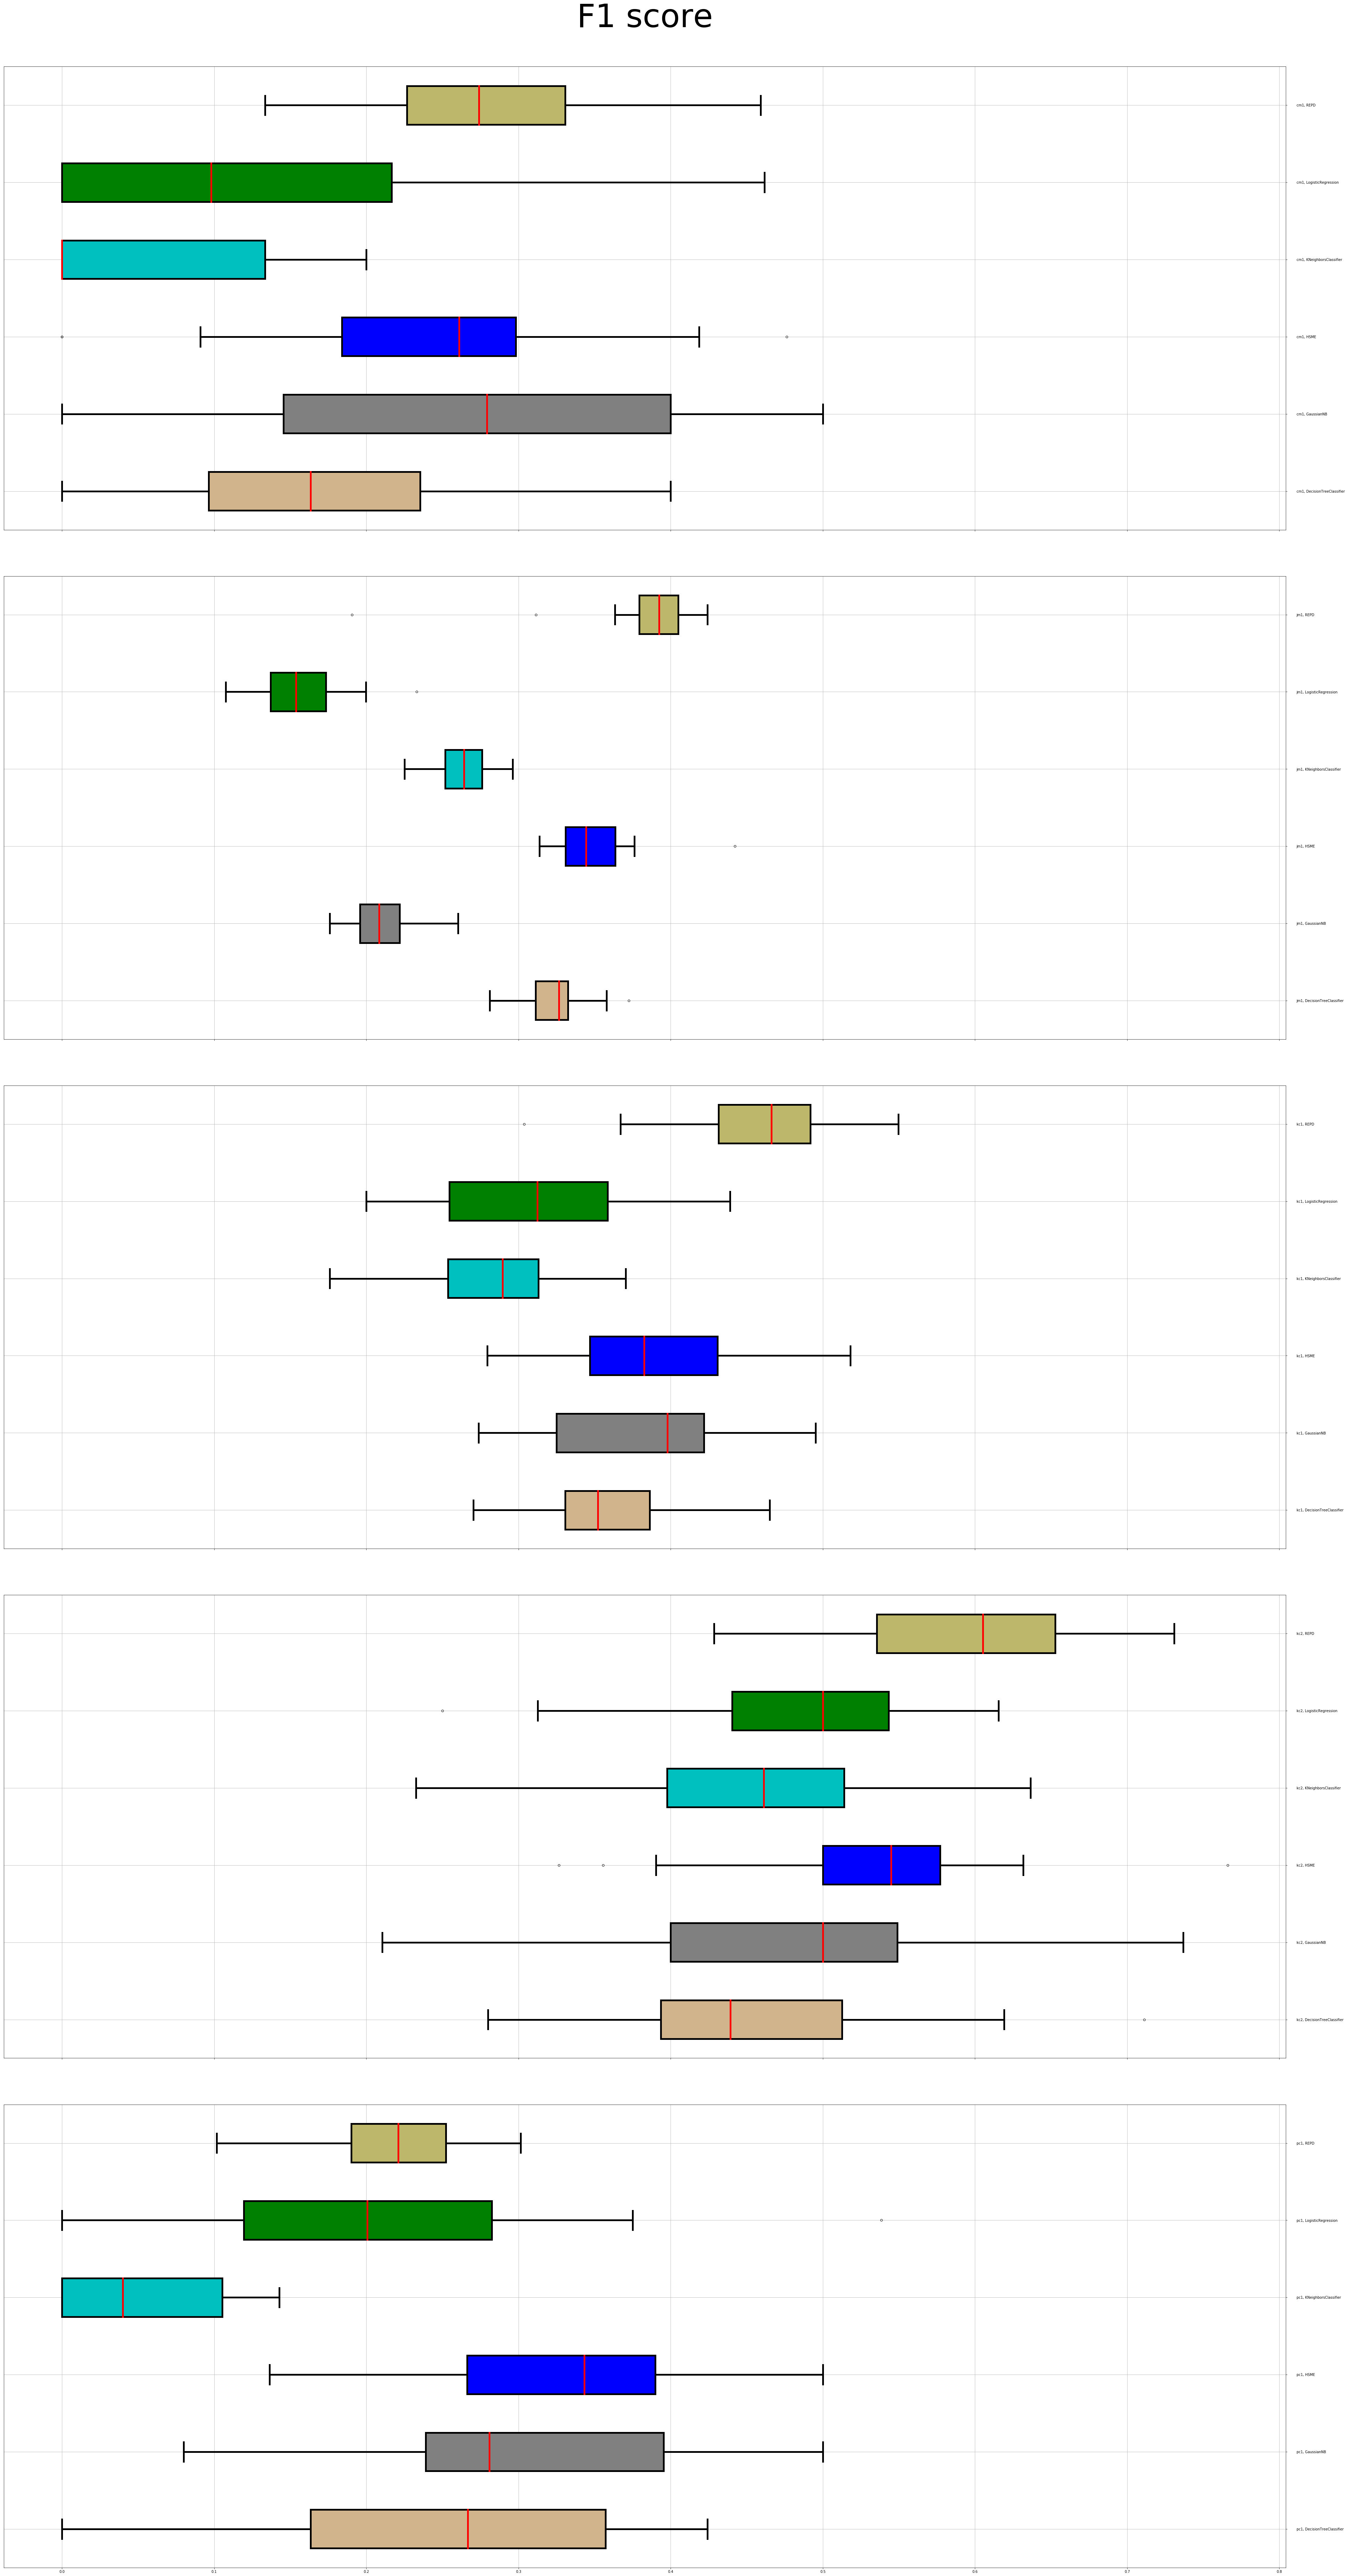

In [8]:
df = main_df.drop(columns=["Recall","PD","PF",'Accuracy', 'Precision'])
new_dfs = []

dataset_list = list(set(df.Dataset.values))
dataset_list.sort()

for n, dataset in enumerate(dataset_list):
    new_df = []
    
    for model in list(set(df.Model.values)):
        f1_scores = []
        temp = df.loc[(df['Dataset'] == dataset) & (df['Model'] == model)]['F1 score'].values
        for value in temp:
            d = {
                'DatasetModel' : '{: <26}'.format(", ".join([dataset, model])), 'F1 score' : value
            }
            new_df.append(d)
            
    new_df = pd.DataFrame(new_df)
    new_dfs.append(new_df)

fig, axs = plt.subplots(5, 1, figsize=(64,128), sharex=True, sharey="row", gridspec_kw={'hspace': 0.1})

font = {'size': 64}
matplotlib.rc('font', **font)

for n, new_df in enumerate(new_dfs):
    
    bp_dict = new_df.boxplot(
        column="F1 score",
        by=["DatasetModel"],
        layout=(1,1),       
        return_type='both',
        patch_artist = True,
        vert=False,
        ax=axs[n]
    )

    colors = ['tan', 'gray', 'blue', 'c', 'green', 'darkkhaki']

    for row_key, (ax,row) in bp_dict.iteritems():
        yax = ax.get_yaxis()
        yax.set_ticks_position('right')
        pad = max([len(i) for i in new_df['DatasetModel'].values])
        yax.set_tick_params(pad=pad)
        xax = ax.get_xaxis()
        ax.set_title("")
        x_label = xax.get_label()
        x_label.set_visible(False)
        for i,box in enumerate(row['boxes']):
            box.set_color(colors[i%6])
            box.set_edgecolor("black")
            box.set_linewidth(5)
        for item in row['medians']:
            item.set_color('red')
            item.set_linewidth(5)
        for item in row['whiskers']:
            item.set_color("black")
            item.set_linewidth(5)
        for item in row["caps"]:
            item.set_color("black")
            item.set_linewidth(5)   

fig.suptitle("F1 score")
st = fig.suptitle("F1 score", fontsize="x-large")
st.set_y(0.95)
fig.subplots_adjust(top=0.93)
fig.tight_layout()
plt.tight_layout()
plt.savefig("results.pdf",format='pdf',bbox_inches='tight')
plt.show()

In [9]:
import seaborn as sns

In [10]:
def plot_measure(measure_name,plot_name):
    df = main_df.drop(columns=["PD","PF"])
    new_dfs = []

    dataset_list = list(set(df.Dataset.values))
    dataset_list.sort()

    for n, dataset in enumerate(dataset_list):
        new_df = []

        for model in list(set(df.Model.values)):
            f1_scores = []
            temp = df.loc[(df['Dataset'] == dataset) & (df['Model'] == model)][measure_name].values
            for value in temp:
                d = {
                    'DatasetModel' : '{: <26}'.format(", ".join([dataset, model])), measure_name : value
                }
                new_df.append(d)

        new_df = pd.DataFrame(new_df)
        new_dfs.append(new_df)

    #Plotting prepared dataset
    fig, axs = plt.subplots(5, 1, figsize=(64,128), sharex=True, sharey="row", gridspec_kw={'hspace': 0.1})

    font = {'size': 64}
    matplotlib.rc('font', **font)
    for n, new_df in enumerate(new_dfs):
        dataset = dataset_list[n]
        ax=axs[n]
        sns.violinplot(measure_name,'DatasetModel', data=new_df, ax = ax)
        #
        yax = ax.get_yaxis()
        yax.grid(True)
        yax.set_ticks_position('right')
        pad = max([len(i) for i in new_df['DatasetModel'].values])
        yax.set_tick_params(pad=pad)
        y_label = yax.get_label()
        y_label.set_visible(False)
        #
        xax = ax.get_xaxis()
        xax.grid(True)
        x_label = xax.get_label()
        x_label.set_visible(False)
        #
        ax.set_title("")

    fig.suptitle(measure_name)
    st = fig.suptitle(measure_name, fontsize="x-large")
    st.set_y(0.95)
    fig.subplots_adjust(top=0.93)
    fig.tight_layout()
    plt.tight_layout()
    plt.savefig(plot_name,format='pdf',bbox_inches='tight')
    plt.show()

/home/paf/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/paf/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/paf/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


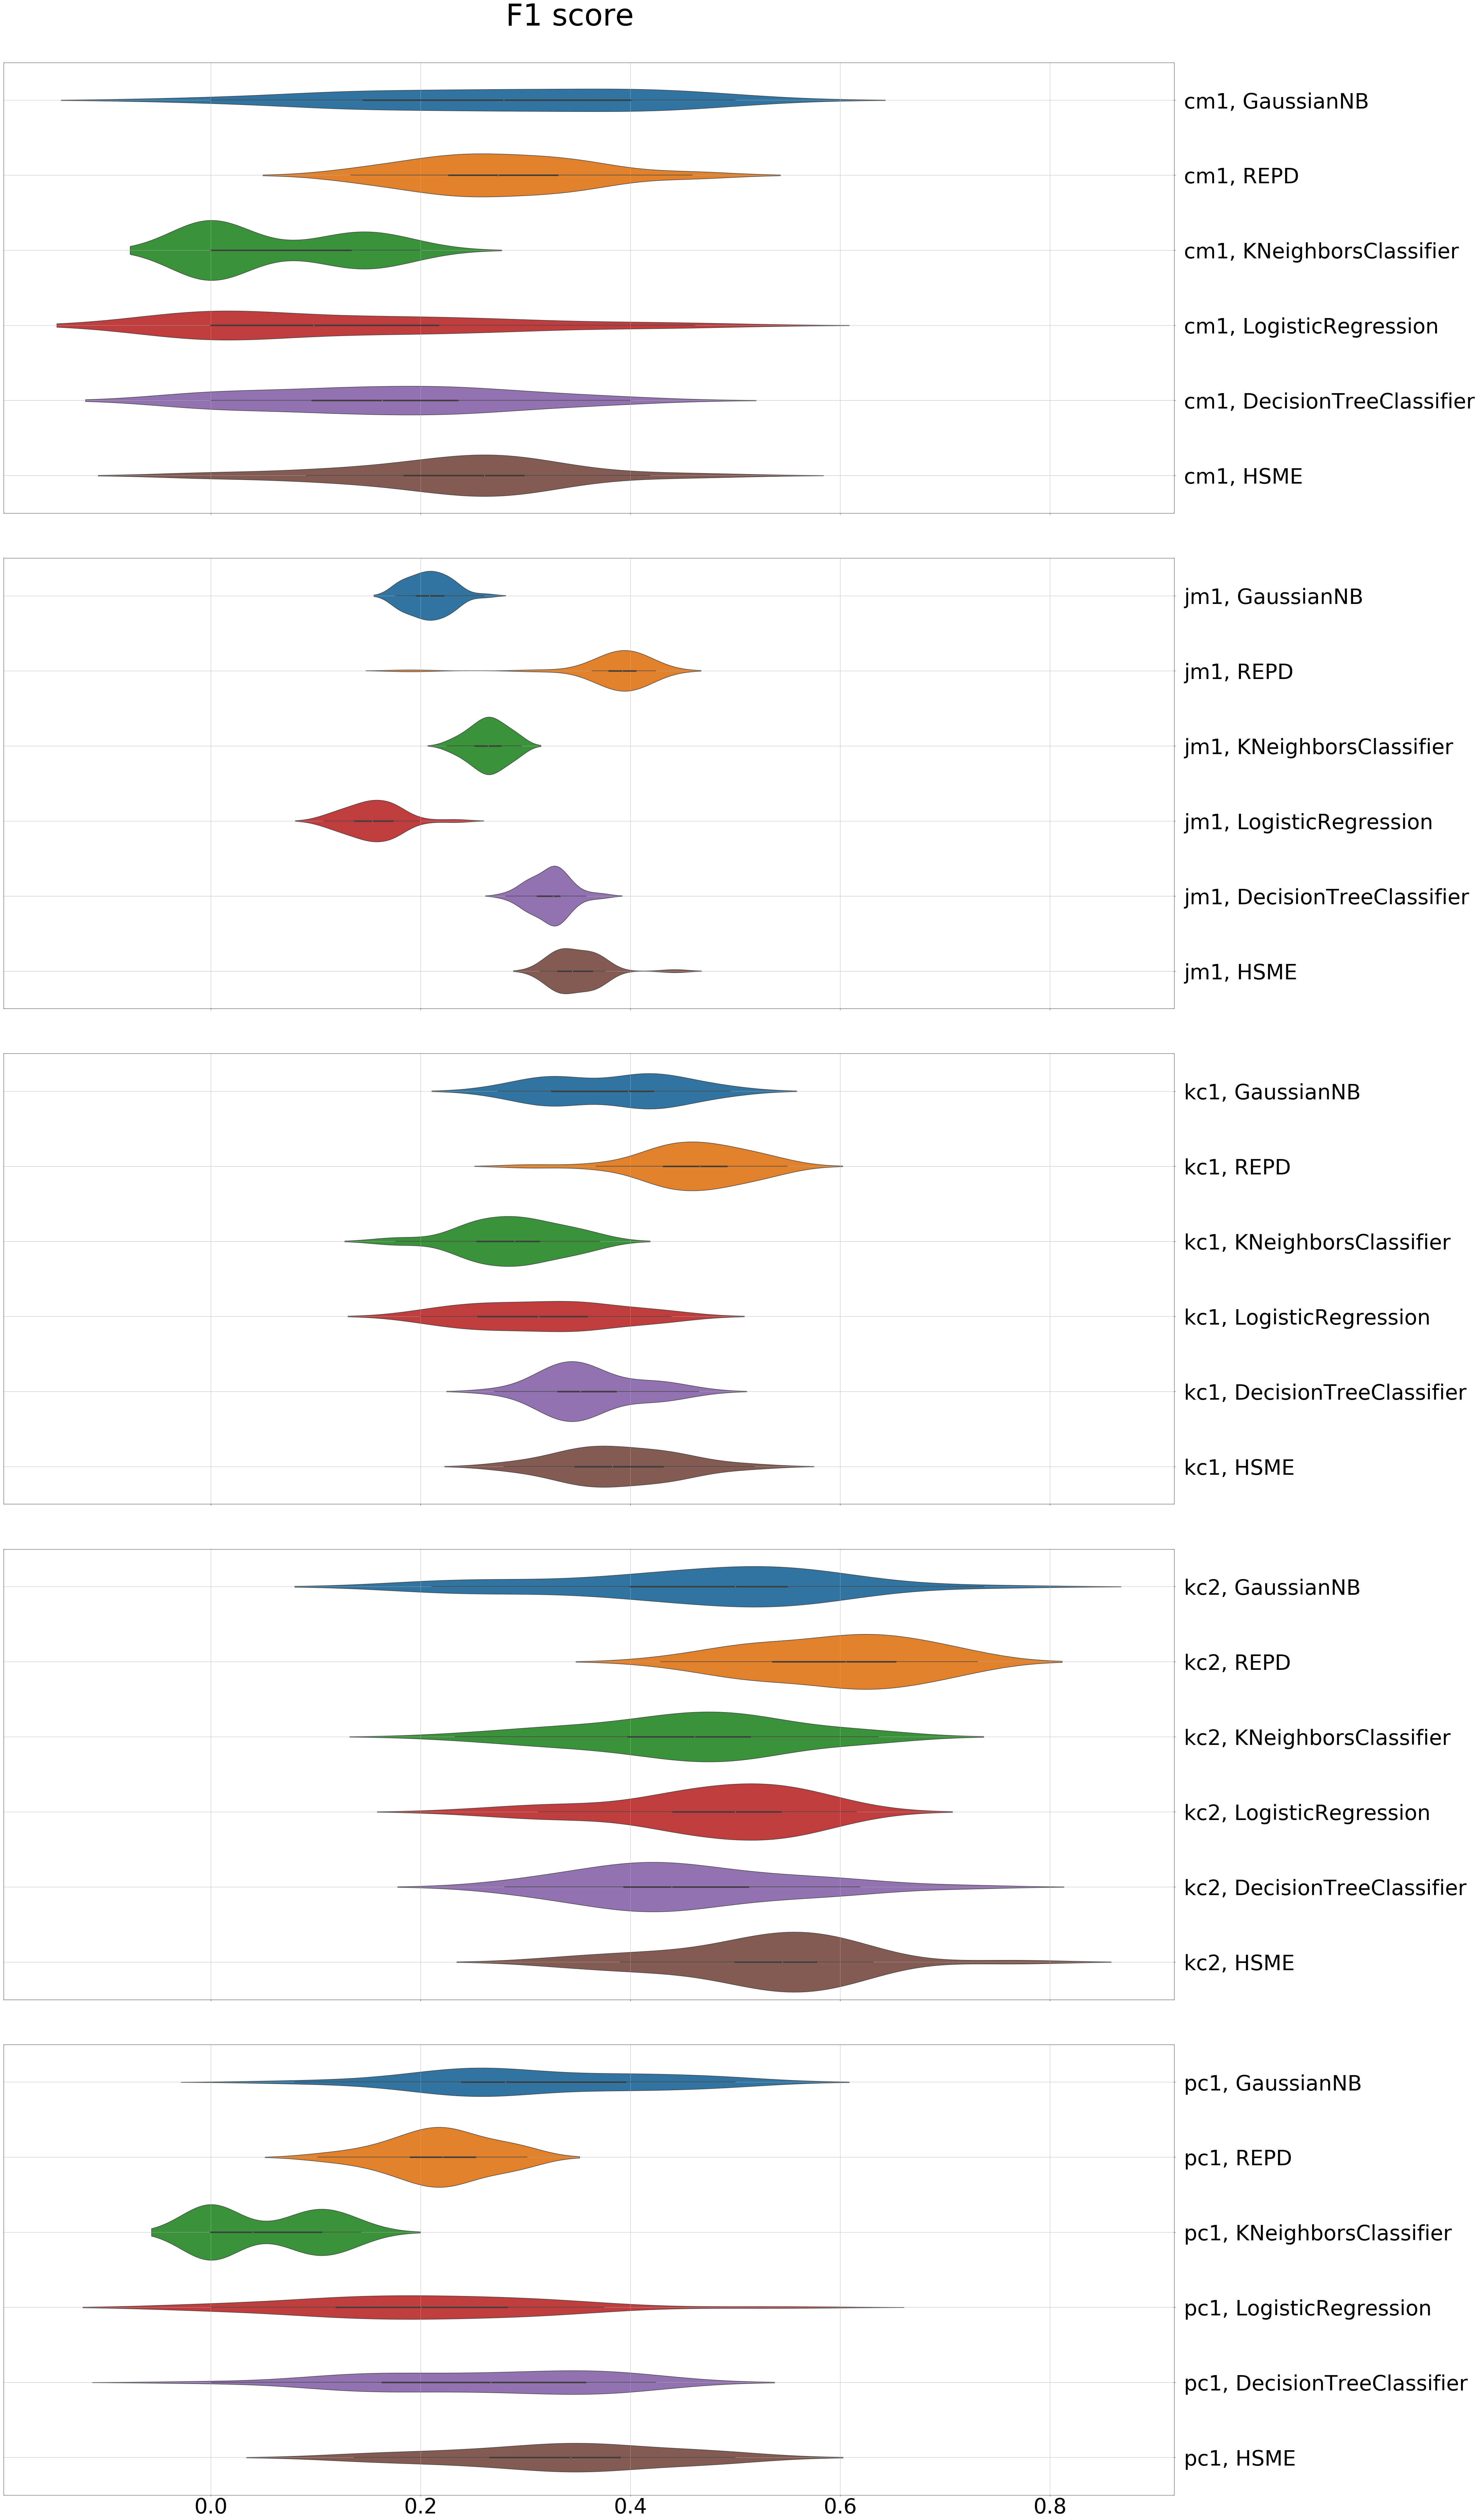

In [11]:
plot_measure("F1 score","f1-results.pdf")

/home/paf/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/paf/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


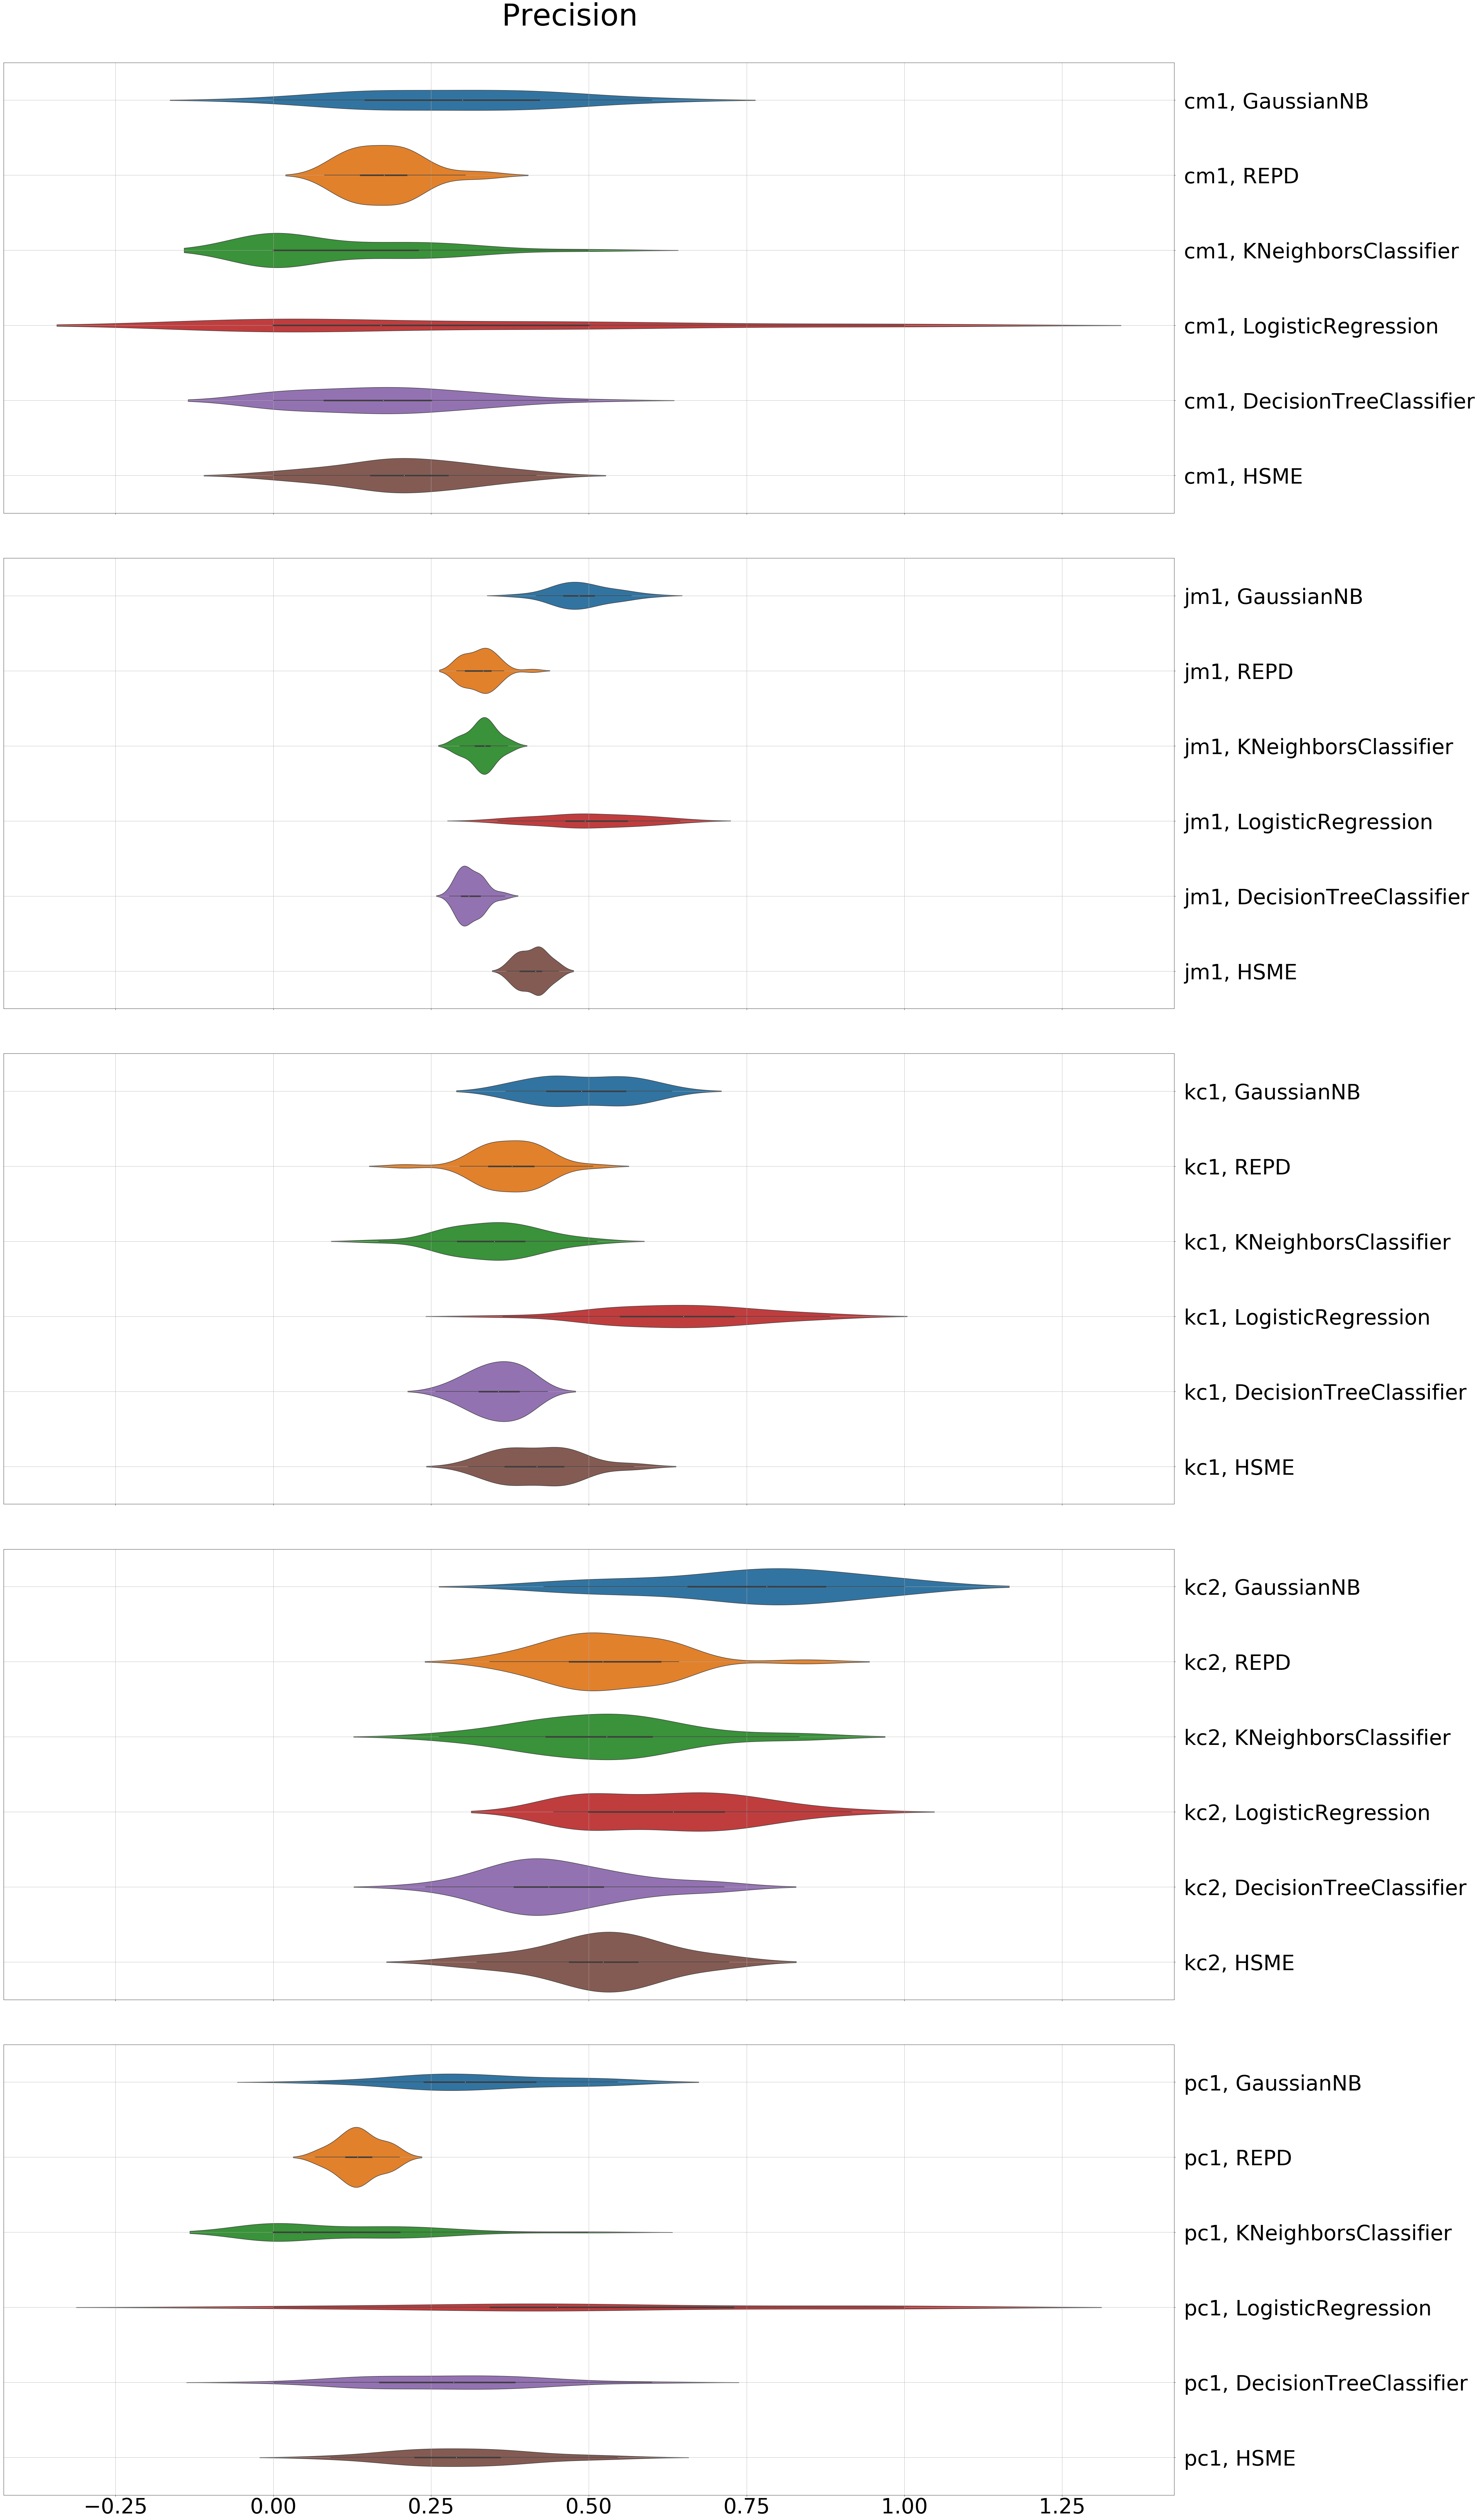

In [12]:
plot_measure("Precision","precision-results.pdf")

/home/paf/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/paf/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


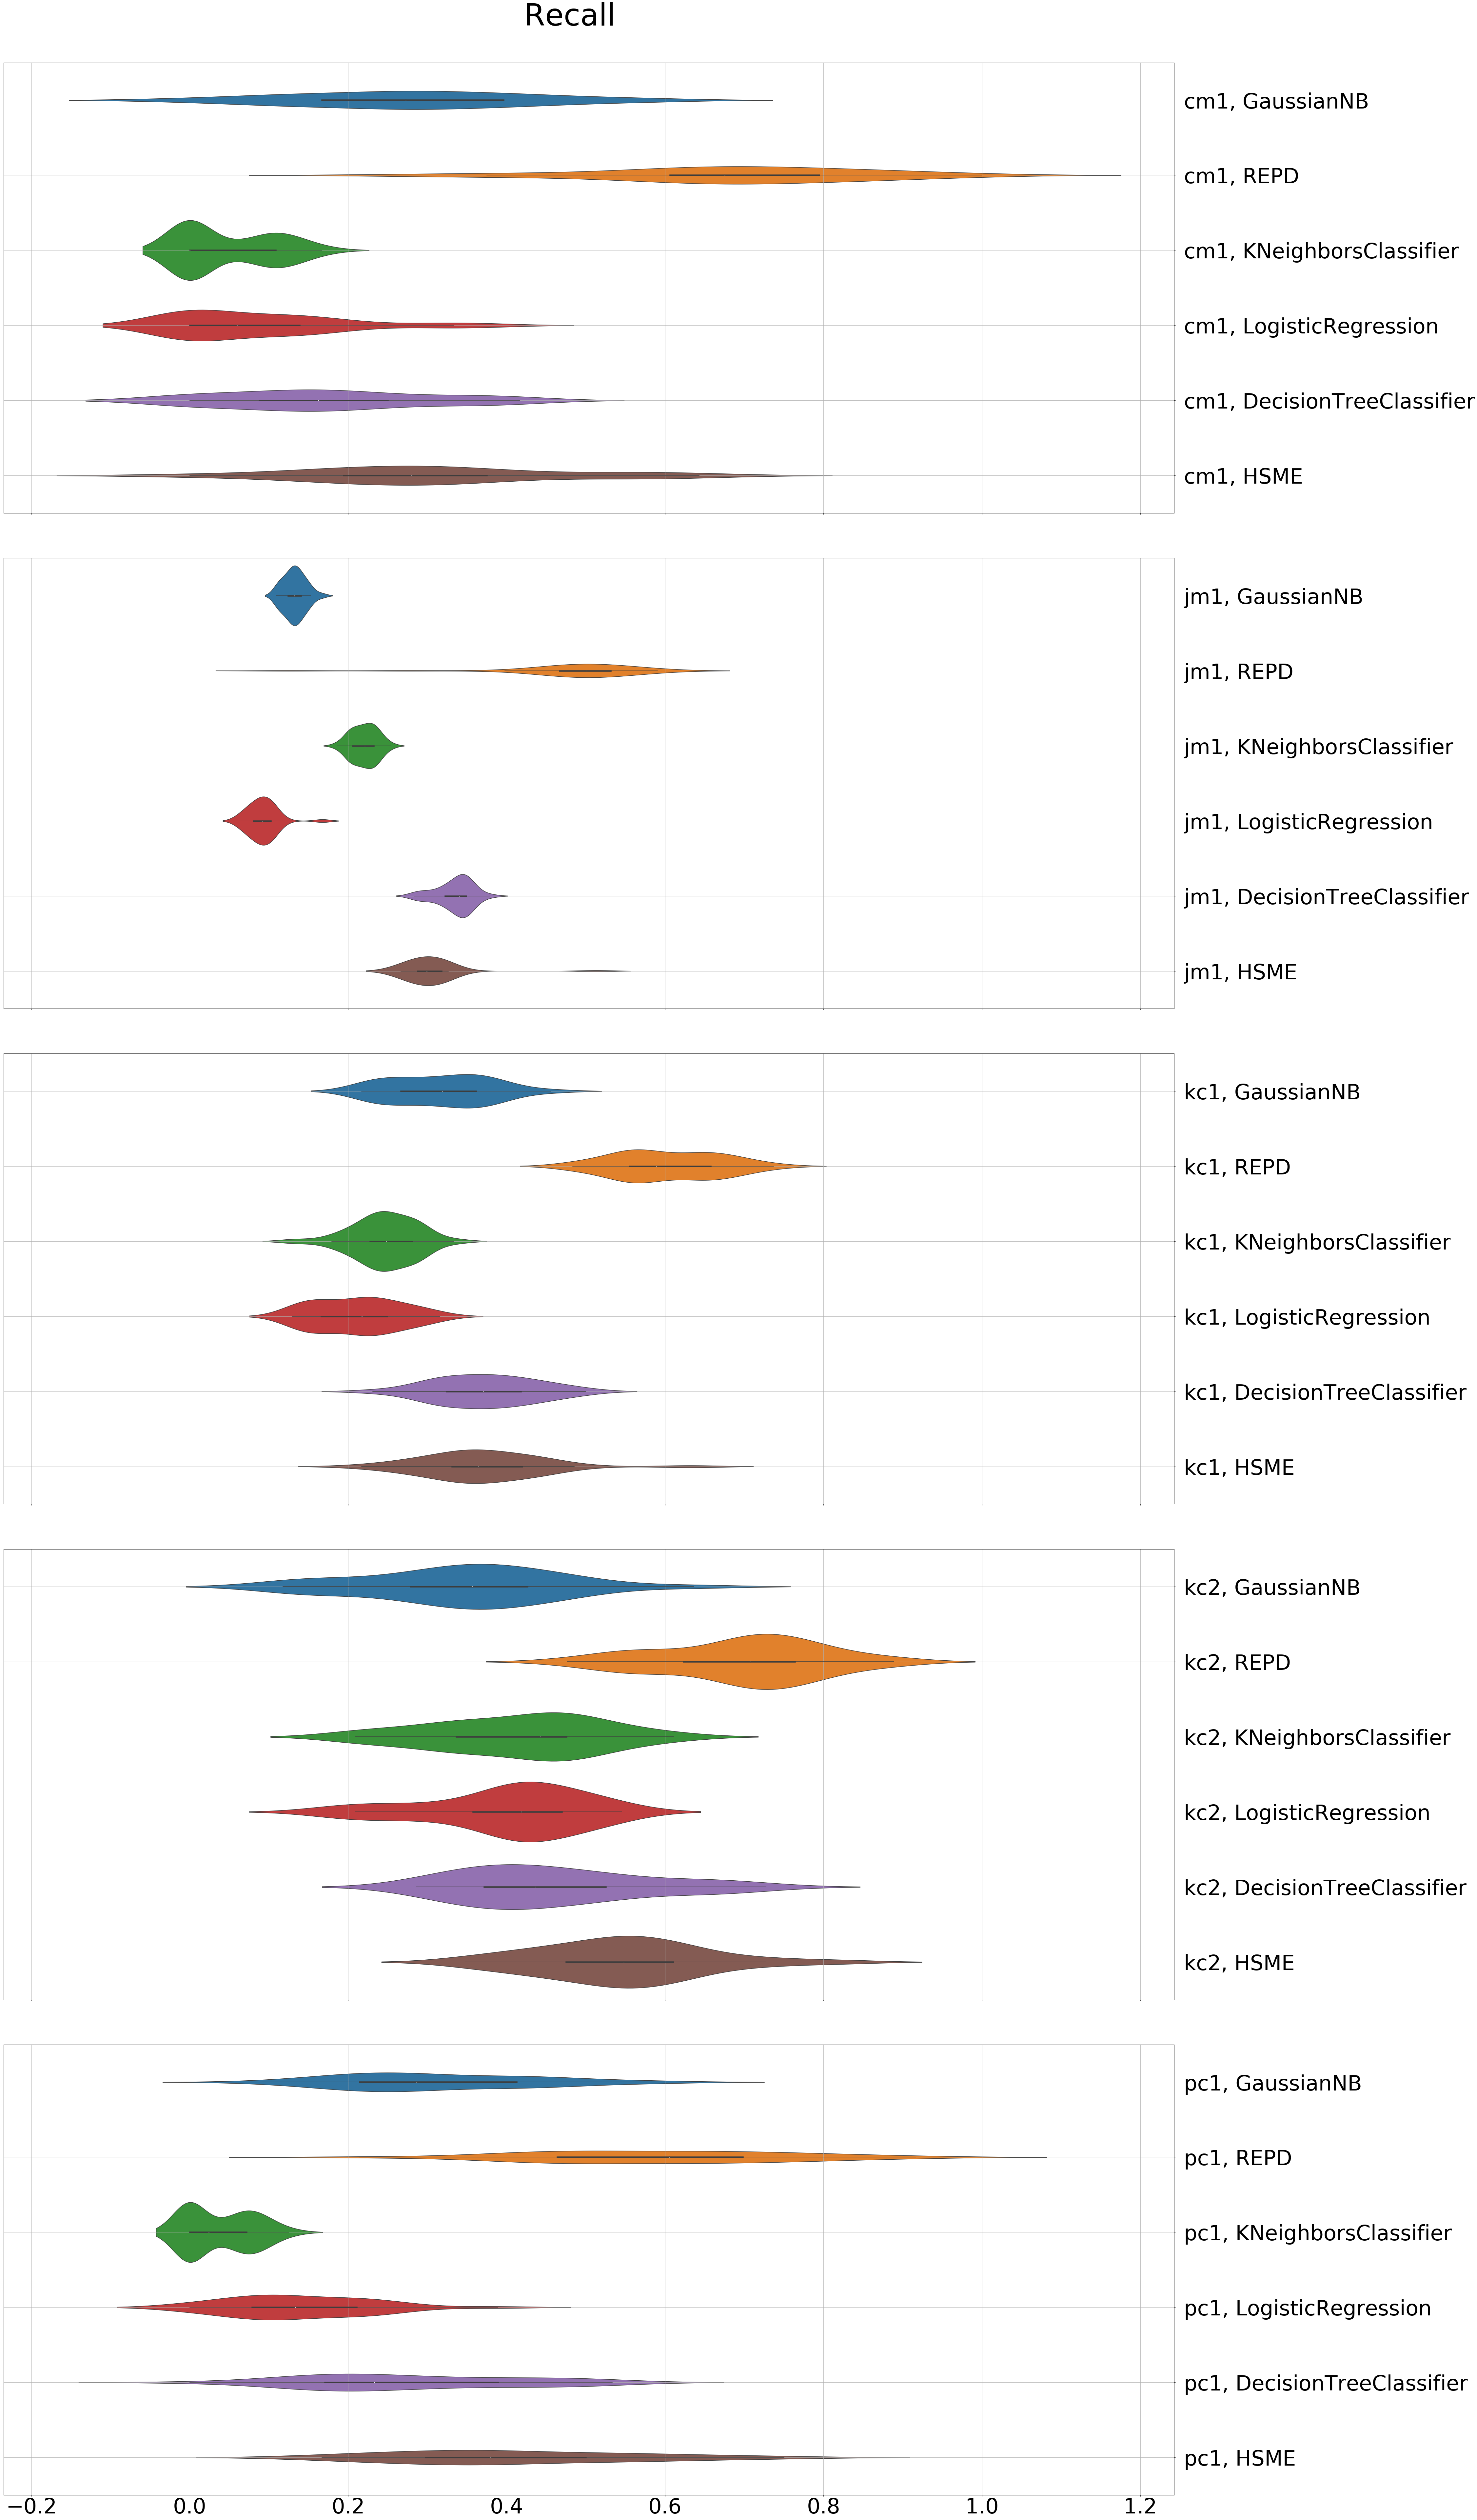

In [13]:
plot_measure("Recall","recall-results.pdf")